In [1]:
trainDir = "training"
testDir = "validation"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization, Reshape, Add, Input, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import class_weight 

In [3]:
def transformer_block(units, num_heads, ff_dim=128, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(1, units))
    
    # Multi-Head Self-Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=units)(inputs, inputs)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Feed-Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(units)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    outputs = LayerNormalization()(ffn_output)
    
    return tf.keras.Model(inputs, outputs)

In [6]:
# Step 1: Data Preprocessing

splits = [0.2]  # Example: 8:2 
results = []

for i, split in enumerate(splits, start=1):
    data_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=split)
    
    train_data = data_gen.flow_from_directory(
        trainDir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    val_data = data_gen.flow_from_directory(
        trainDir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

transformer = transformer_block(units=128, num_heads=4)

# Step 2: Building the CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'), 
    Reshape((1, 128)),                #Reshape to (sequence length, units) for transformer

    #  # Add transformer block
    transformer,

    Flatten(),  # Flatten back for fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

labels = train_data.classes  # Array of 0s and 1s for binary classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Step 3: Training the Model
history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
)
val_loss, val_accuracy = model.evaluate(train_data)





Found 5722 images belonging to 2 classes.
Found 1430 images belonging to 2 classes.
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis h

179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 232ms/step - accuracy: 0.7068 - loss: 0.5816 - val_accuracy: 0.8608 - val_loss: 0.3791
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.8985 - loss: 0.2255 - val_accuracy: 0.8629 - val_loss: 0.3607
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.8971 - loss: 0.2180 - val_accuracy: 0.8406 - val_loss: 0.4708
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.9317 - loss: 0.1603 - val_accuracy: 0.8455 - val_loss: 0.5709
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.9494 - loss: 0.1274 - val_accuracy: 0.8601 - val_loss: 0.5680
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.9635 - loss: 0.1000 - val_accuracy: 0.8517 - val_loss: 0.8600
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9737 - loss: 0.0747 - val_accuracy: 0.8874 - val_loss: 0.8342
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.9814 - loss: 0.0465 - val

In [7]:
import pandas as pd
results.append({
        "No": i,
        "Training Images": train_data.samples,
        "Testing Images": val_data.samples,
        "Splitting Ratio": f"{int((1 - split) * 10)}:{int(split * 10)}",
        "Accuracy (%)": round(val_accuracy * 100, 2)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   No  Training Images  Testing Images Splitting Ratio  Accuracy (%)
0   1             5722            1430             8:2         99.46


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

# Step 1: Get Predictions
val_predictions = model.predict(val_data)
val_predictions = (val_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Step 2: Get True Labels
val_labels = val_data.classes  # Ground truth labels

# Step 3: Calculate Precision, Recall, and F1-Score
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")



 2/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Precision: 0.69
Recall: 0.80
F1-Score: 0.74


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


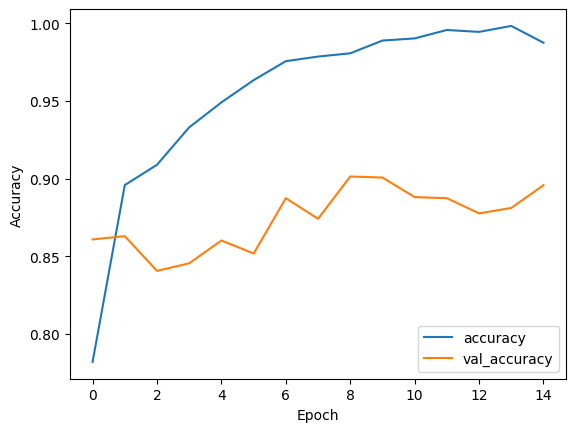

In [9]:
# Step 4: Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [30]:
def predict_tumor(image_path, threshold=0.5):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    confidence = prediction[0][0] * 100  # Convert to percentage
    
    # Determine the result
    if prediction[0] > threshold:
        result = "Tumor Detected"
        confidence_level = confidence  # Confidence for "Tumor Detected"
    else:
        result = "No Tumor Detected"
        confidence_level = 100 - confidence  # Confidence for "No Tumor Detected"
    
    return result, confidence_level


In [31]:
result, confidence = predict_tumor("/Users/dpak/Desktop/brain/a.jpg")
print(f"Prediction: {result}, Confidence Level: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction: Tumor Detected, Confidence Level: 100.00%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Step 1: Prepare the data
# Flatten the images and reshape for Random Forest
train_images = np.concatenate([train_data[i][0] for i in range(len(train_data))])
train_labels = np.concatenate([train_data[i][1] for i in range(len(train_data))])

val_images = np.concatenate([val_data[i][0] for i in range(len(val_data))])
val_labels = np.concatenate([val_data[i][1] for i in range(len(val_data))])

# Flatten images for Random Forest
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)

# Step 2: Train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_images_flat, train_labels)

# Step 3: Predict and Evaluate
val_predictions_rf = rf_model.predict(val_images_flat)

# Calculate metrics
accuracy_rf = accuracy_score(val_labels, val_predictions_rf)
precision_rf = precision_score(val_labels, val_predictions_rf)
recall_rf = recall_score(val_labels, val_predictions_rf)
f1_rf = f1_score(val_labels, val_predictions_rf)

print(f"Random Forest - Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest - Precision: {precision_rf:.2f}")
print(f"Random Forest - Recall: {recall_rf:.2f}")
print(f"Random Forest - F1-Score: {f1_rf:.2f}")




Random Forest - Accuracy: 0.80
Random Forest - Precision: 0.87
Random Forest - Recall: 0.84
Random Forest - F1-Score: 0.85


In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Prepare the data
# Flatten the images and reshape for SVM
train_images = np.concatenate([train_data[i][0] for i in range(len(train_data))])
train_labels = np.concatenate([train_data[i][1] for i in range(len(train_data))])

val_images = np.concatenate([val_data[i][0] for i in range(len(val_data))])
val_labels = np.concatenate([val_data[i][1] for i in range(len(val_data))])

# Flatten images for SVM
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)

# Standardize the data (important for SVM)
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_flat)
val_images_scaled = scaler.transform(val_images_flat)

# Step 2: Train the SVM Classifier
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(train_images_scaled, train_labels)

# Step 3: Predict and Evaluate
val_predictions_svm = svm_model.predict(val_images_scaled)

# Calculate metrics
accuracy_svm = accuracy_score(val_labels, val_predictions_svm)
precision_svm = precision_score(val_labels, val_predictions_svm)
recall_svm = recall_score(val_labels, val_predictions_svm)
f1_svm = f1_score(val_labels, val_predictions_svm)

print(f"SVM - Accuracy: {accuracy_svm:.2f}")
print(f"SVM - Precision: {precision_svm:.2f}")
print(f"SVM - Recall: {recall_svm:.2f}")
print(f"SVM - F1-Score: {f1_svm:.2f}")



SVM - Accuracy: 0.85
SVM - Precision: 0.85
SVM - Recall: 0.95
SVM - F1-Score: 0.90
